In [207]:
#Importing needed modules.
from os import listdir, mkdir
from shutil import rmtree , copyfile
from random import sample
from matplotlib.pyplot import plot , xlabel , ylabel , title , legend ,show
from tensorflow.keras.preprocessing.image import load_img , ImageDataGenerator
from tensorflow.keras import layers , Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import InceptionV3
#Instancing from 'ImageDataGenerator' object
generator = ImageDataGenerator(rescale=1/255)

In [208]:
#Creating a function for making basic paths.
def Make_paths(base_path,classes)->str:
    '''function docstring'''
    if 'ready_to_generate' in listdir(base_path) :
        rmtree(f'{base_path}\\ready_to_generate')
    mkdir(f'{base_path}\\ready_to_generate')
    mkdir(f'{base_path}\\ready_to_generate\\train')
    mkdir(f'{base_path}\\ready_to_generate\\validation')
    for name in classes :
        mkdir(f'{base_path}\\ready_to_generate\\train\\{name}')
        mkdir(f'{base_path}\\ready_to_generate\\validation\\{name}')
    return f'{base_path}\\ready_to_generate\\train' , f'{base_path}\\ready_to_generate\\validation'

In [209]:
#Creating a function to split pictures(and their masks).
def Move_photos(base_path,tr_pth,val_pth,tr_size)->None :
    '''function doctsring'''
    label = base_path.split('\\')[-1]
    original_photos = [pic for pic in listdir(base_path) if 'mask' not in pic ]
    split_size = (tr_size*len(original_photos))//100
    selected_photos = sample(original_photos,split_size)
    for pic in original_photos :
        try :
            load_img(f'{base_path}\\{pic}')
            if pic in selected_photos :
                copyfile(f'{base_path}\\{pic}',f'{tr_pth}\\{label}\\{pic}')
                mask = ''
                for letter in pic :
                    if letter == ')' :
                        mask += ')_mask'
                        continue
                    mask += letter
                copyfile(f'{base_path}\\{mask}',f'{tr_pth}\\{label}\\{mask}')
            else :
                copyfile(f'{base_path}\\{pic}',f'{val_pth}\\{label}\\{pic}')
                mask = ''
                for letter in pic :
                    if letter == ')' :
                        mask += ')_mask'
                        continue
                    mask += letter
                copyfile(f'{base_path}\\{mask}',f'{val_pth}\\{label}\\{mask}')
        except :
            print(f'{pic} is zero length, so ignoring...')

In [210]:
base = 'D:\\datasets\\Dataset_BUSI_with_GT'
Classes = [lbl for lbl in listdir(base) if lbl != 'ready_to_generate']
#Storing train and valid paths in two variables.
train , valid = Make_paths(base,Classes)
#Splitting photos.
size = int(input('Enter train size :'))
for name in Classes:
    Move_photos(f'D:\\datasets\\Dataset_BUSI_with_GT\\{name}',
                train,
                valid,
                size)

Enter train size :80


In [211]:
#Generating photos.
ready_train = generator.flow_from_directory(train,target_size=(150,150),batch_size=12)
ready_valid = generator.flow_from_directory(valid,target_size=(150,150),batch_size=6)

Found 1246 images belonging to 3 classes.
Found 314 images belonging to 3 classes.


In [212]:
#Defining a model by defining a function.
def Teacher(active,optm,Loss,Metric,pre_trained_model)->None:
    '''function docstring'''
    pre = pre_trained_model(include_top=False,input_shape=(150,150,3))
    for layer in pre.layers :
        layer.trainable = False
    last_layer = pre.get_layer('mixed7')
    last_out = last_layer.output
    x = layers.Flatten()(last_out)
    x = layers.Dropout(0.55)(x)
    x = layers.Dense(3,activation=active)(x)
    model = Model(pre.input,x)
    model.compile(optimizer=optm,
                 loss=Loss,
                 metrics=[Metric])
    return model

In [213]:
#Data train.
history = Teacher('softmax',
                  RMSprop(learning_rate=0.001),
                  'categorical_crossentropy',
                  'accuracy',InceptionV3).fit(ready_train,epochs=10,validation_data=(ready_valid))

Epoch 1/10
104/104 [==============================] - 19s 165ms/step - loss: 0.8124 - accuracy: 0.7544 - val_loss: 0.5162 - val_accuracy: 0.8217
Epoch 2/10
104/104 [==============================] - 16s 150ms/step - loss: 0.3575 - accuracy: 0.8756 - val_loss: 0.2659 - val_accuracy: 0.9204
Epoch 3/10
104/104 [==============================] - 16s 151ms/step - loss: 0.2421 - accuracy: 0.9165 - val_loss: 0.3549 - val_accuracy: 0.9140
Epoch 4/10
104/104 [==============================] - 17s 160ms/step - loss: 0.1847 - accuracy: 0.9462 - val_loss: 0.3584 - val_accuracy: 0.8949
Epoch 5/10
104/104 [==============================] - 16s 158ms/step - loss: 0.1439 - accuracy: 0.9559 - val_loss: 0.3558 - val_accuracy: 0.9268
Epoch 6/10
104/104 [==============================] - 16s 158ms/step - loss: 0.1250 - accuracy: 0.9526 - val_loss: 0.4880 - val_accuracy: 0.8344
Epoch 7/10
104/104 [==============================] - 16s 159ms/step - loss: 0.1065 - accuracy: 0.9663 - val_loss: 0.2808 - val_ac

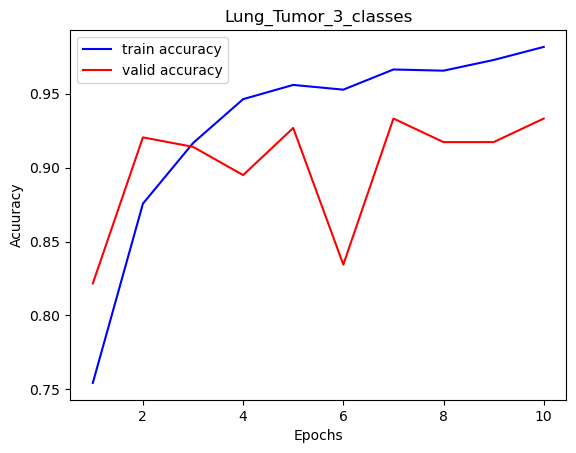

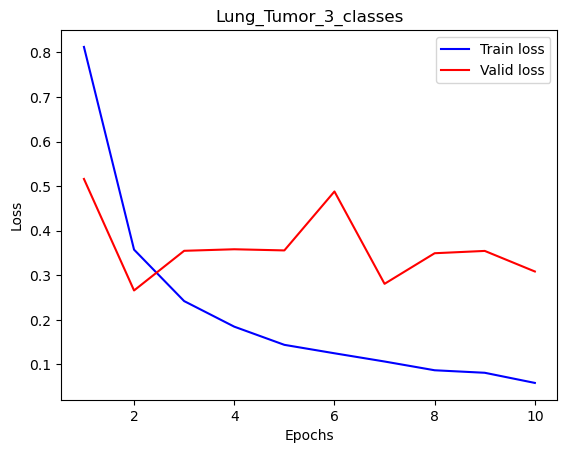

In [214]:
#Visualize models performance on accuracy.
result = history.history
x = range(1,len(history.epoch)+1)
y = result['accuracy']
y_val = result['val_accuracy']
plot(x,y,'blue')
plot(x,y_val,'red')
xlabel('Epochs')
ylabel('Acuuracy')
title('Breast_Tumor_3_classes')
legend(['train accuracy','valid accuracy'])
show()
#Visualize models performance on loss.
x = range(1,len(history.epoch)+1)
y = result['loss']
y_val = result['val_loss']
plot(x,y,'blue')
plot(x,y_val,'red')
xlabel('Epochs')
ylabel('Loss')
title('Breast_Tumor_3_classes')
legend(['Train loss','Valid loss'])
show()